# Import the libraries

In [20]:
from preprocessing_CNN import Train_Validation_Test_Split

import numpy as np
import pandas as pd

import os
import shutil

import pickle as pk

import cv2 
import matplotlib.pyplot as plt
%matplotlib inline 

from keras import layers
from keras import models
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model

from keras.applications import VGG19

# Data pre-processing

## Train-Validation-Test Split

In [21]:
c_train, d_train, c_val, d_val, c_test, d_test = Train_Validation_Test_Split('cats', 'dogs')

Final number of cat pictures: 12500
Final number of dog pictures: 12500

-----------------------------------------------------------------

Start to determine test, validation and train part
Stop to determine test, validation and train part

Start to set folder structure
Stop to set folder structure

Start copying the determined images to the appropriate folders
Stop copying the determined images to the appropriate folders

-----------------------------------------------------------------

          The final data breakdown is as follows:

Total training cat images: 7500
Total training dog images: 7500

Total validation cat images: 2500
Total validation dog images: 2500

Total test cat images: 2500
Total test dog images: 2500


## Obtaining the lists of randomly selected images

In [22]:
list_cats_training = c_train
list_dogs_training = d_train

list_cats_validation = c_val
list_dogs_validation = d_val

list_cats_test = c_test
list_dogs_test = d_test

## Determination of the directories

In [23]:
root_directory = os.getcwd()

train_dir = os.path.join(root_directory, 'cats_and_dogs\\train')
validation_dir = os.path.join(root_directory, 'cats_and_dogs\\validation')
test_dir = os.path.join(root_directory, 'cats_and_dogs\\test')

## Obtain the total number of training, validation and test images

In [24]:
num_cats_img_train = len(list_cats_training)
num_dogs_img_train = len(list_dogs_training)

num_train_images_total = num_cats_img_train + num_dogs_img_train

print('Total training cat images: ' + str(num_cats_img_train))
print('Total training dog images: ' + str(num_dogs_img_train))
print()
print('Total training images: ' + str(num_train_images_total))

Total training cat images: 7500
Total training dog images: 7500

Total training images: 15000


In [25]:
num_cats_img_validation = len(list_cats_validation)
num_dogs_img_validation = len(list_dogs_validation)

num_validation_images_total = num_cats_img_validation + num_dogs_img_validation

print('Total validation cat images: ' + str(num_cats_img_validation))
print('Total validation dog images: ' + str(num_dogs_img_validation))
print()
print('Total validation images: ' + str(num_validation_images_total))

Total validation cat images: 2500
Total validation dog images: 2500

Total validation images: 5000


In [26]:
num_cats_img_test = len(list_cats_test)
num_dogs_img_test = len(list_dogs_test)

num_test_images_total = num_cats_img_test + num_dogs_img_test

print('Total test cat images: ' + str(num_cats_img_test))
print('Total test dog images: ' + str(num_dogs_img_test))
print()
print('Total test images: ' + str(num_test_images_total))

Total test cat images: 2500
Total test dog images: 2500

Total test images: 5000


# Feature Extraction with Data Augmentation

## Name Definitions

In [27]:
checkpoint_no = 'ckpt_1_CNN_with_TFL_VGG19_FineTuning'
model_name = 'Cats_Dogs_CNN_TFL_VGG19_FineTuning_epoch_30'

## Parameter Settings

In [28]:
img_height = 150
img_width = 150
input_shape = (img_height, img_width, 3)

n_batch_size = 32

n_steps_per_epoch = int(num_train_images_total / n_batch_size)
n_validation_steps = int(num_validation_images_total / n_batch_size)
n_test_steps = int(num_test_images_total / n_batch_size)

n_epochs = 30

print('Input Shape: '+'('+str(img_height)+', '+str(img_width)+', ' + str(3)+')')
print('Batch Size: ' + str(n_batch_size))
print()
print('Steps per Epoch: ' + str(n_steps_per_epoch))
print()
print('Validation Steps: ' + str(n_validation_steps))
print('Test Steps: ' + str(n_test_steps))
print()
print('Number of Epochs: ' + str(n_epochs))

Input Shape: (150, 150, 3)
Batch Size: 32

Steps per Epoch: 468

Validation Steps: 156
Test Steps: 156

Number of Epochs: 30


## Instantiating the VGG19 convolutional base

In [29]:
VGG19_base = VGG19(weights='imagenet',
                  include_top=False,
                  input_shape=input_shape)

conv_base = VGG19_base

In [30]:
conv_base.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

## Freezing all layers up to a specific one

In [31]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv3':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

## Instantiating a densely connected classifier

### Layer Structure

In [32]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [33]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 22,122,049
Trainable params: 6,817,281
Non-trainable params: 15,304,768
_________________________________________________________________


### Configuring the model for training

In [34]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

### Using ImageDataGenerator

In [35]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

validation_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(img_height, img_width),
        batch_size=n_batch_size,
        class_mode='binary')


validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(img_height, img_width),
        batch_size=n_batch_size,
        class_mode='binary')



Found 15000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


## Callbacks

In [36]:
# Prepare a directory to store all the checkpoints.
checkpoint_dir = checkpoint_no
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

In [37]:
keras_callbacks = [ModelCheckpoint(filepath = checkpoint_dir, 
                                   monitor='val_loss', save_best_only=True, mode='auto'),
                   EarlyStopping(monitor='val_loss', patience=5, mode='auto', 
                                 min_delta = 0, verbose=1)]

## Fitting the model

In [38]:
history = model.fit(
      train_generator,
      steps_per_epoch=n_steps_per_epoch,
      epochs=n_epochs,
      validation_data=validation_generator,
      validation_steps=n_validation_steps,
      callbacks=keras_callbacks)

Epoch 1/30
468/468 [==============================] - 1722s 4s/step - loss: 0.6288 - accuracy: 0.7369 - val_loss: 0.4015 - val_accuracy: 0.8265
INFO:tensorflow:Assets written to: ckpt_1_CNN_with_TFL_VGG19_FineTuning\assets
Epoch 2/30
468/468 [==============================] - 1712s 4s/step - loss: 0.3270 - accuracy: 0.8559 - val_loss: 0.2257 - val_accuracy: 0.9028
INFO:tensorflow:Assets written to: ckpt_1_CNN_with_TFL_VGG19_FineTuning\assets
Epoch 3/30
468/468 [==============================] - 1757s 4s/step - loss: 0.2900 - accuracy: 0.8781 - val_loss: 0.2408 - val_accuracy: 0.8936
Epoch 4/30
468/468 [==============================] - 1729s 4s/step - loss: 0.2652 - accuracy: 0.8887 - val_loss: 0.1961 - val_accuracy: 0.9197
INFO:tensorflow:Assets written to: ckpt_1_CNN_with_TFL_VGG19_FineTuning\assets
Epoch 5/30
468/468 [==============================] - 1700s 4s/step - loss: 0.2391 - accuracy: 0.8995 - val_loss: 0.2127 - val_accuracy: 0.9095
Epoch 6/30
468/468 [=======================

## Obtaining the best model values

In [39]:
hist_df = pd.DataFrame(history.history)
hist_df['epoch'] = hist_df.index + 1
cols = list(hist_df.columns)
cols = [cols[-1]] + cols[:-1]
hist_df = hist_df[cols]
hist_df.to_csv(checkpoint_no + '/' + 'history_df_' + model_name + '.csv')
hist_df.head()

,epoch,loss,accuracy,val_loss,val_accuracy
0,1,0.459657,0.797100,0.401543,0.826522
1,2,0.317757,0.860102,0.225670,0.902845
2,3,0.291272,0.875534,0.240783,0.893630
3,4,0.272913,0.886358,0.196120,0.919671
4,5,0.243187,0.896245,0.212684,0.909455


In [40]:
values_of_best_model = hist_df[hist_df.val_loss == hist_df.val_loss.min()]
values_of_best_model

,epoch,loss,accuracy,val_loss,val_accuracy
16,17,0.172725,0.926577,0.161938,0.936298


## Obtaining class assignments

In [41]:
class_assignment = train_generator.class_indices

df = pd.DataFrame([class_assignment], columns=class_assignment.keys())
df_stacked = df.stack()
df_temp = pd.DataFrame(df_stacked).reset_index().drop(['level_0'], axis=1)
df_temp.columns = ['Category', 'Allocated Number']
df_temp.to_csv(checkpoint_no + '/' + 'class_assignment_df_' + model_name + '.csv')

print('Class assignment:', str(class_assignment))

Class assignment: {'cats': 0, 'dogs': 1}


## Validation

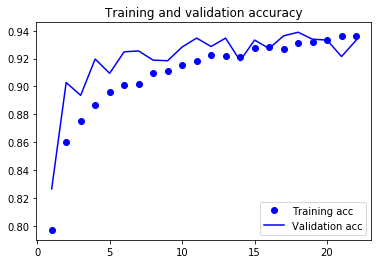

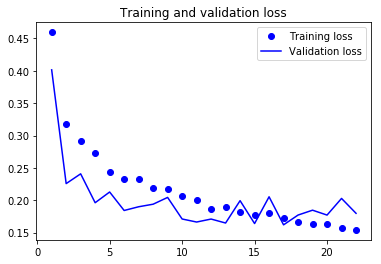

In [42]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Load best model

In [43]:
# Loading the automatically saved model
model_reloaded = load_model(checkpoint_no)

# Saving the best model in the correct path and format
root_directory = os.getcwd()
checkpoint_dir = os.path.join(root_directory, checkpoint_no)
model_name_temp = os.path.join(checkpoint_dir, model_name + '.h5')
model_reloaded.save(model_name_temp)

# Deletion of the automatically created folders/.pb file under Model Checkpoint File.
folder_name_temp1 = os.path.join(checkpoint_dir, 'assets')
folder_name_temp2 = os.path.join(checkpoint_dir, 'variables')
file_name_temp = os.path.join(checkpoint_dir, 'saved_model.pb')

shutil.move(file_name_temp, folder_name_temp1)
shutil.rmtree(folder_name_temp1, ignore_errors=True)
shutil.rmtree(folder_name_temp2, ignore_errors=True)

In [44]:
best_model = load_model(model_name_temp)

## Model Testing

In [45]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(img_height, img_width),
        batch_size=n_batch_size,
        class_mode='binary')

test_loss, test_acc = best_model.evaluate(test_generator, steps=n_test_steps)
print()
print('Test Accuracy:', test_acc)

Found 5000 images belonging to 2 classes.
156/156 [==============================] - 209s 1s/step - loss: 0.1572 - accuracy: 0.9327

Test Accuracy: 0.932692289352417


In [46]:
pk.dump(img_height, open(checkpoint_dir+ '\\' +'img_height.pkl', 'wb'))
pk.dump(img_width, open(checkpoint_dir+ '\\' +'img_width.pkl', 'wb'))

## Test Out of the Box Pictures

In [47]:
# Determine Checkpoint Dir
checkpoint_dir = 'ckpt_1_CNN_with_TFL_VGG19_FineTuning'

# Load best model
best_model = load_model(checkpoint_dir + '/' + 'Cats_Dogs_CNN_TFL_VGG19_FineTuning_epoch_30.h5')

# Load the categories
df = pd.read_csv(checkpoint_dir + '/' + 'class_assignment_df_Cats_Dogs_CNN_TFL_VGG19_FineTuning_epoch_30.csv')
df = df.sort_values(by='Allocated Number', ascending=True)
CATEGORIES = df['Category'].to_list()


# Load the used image height and width
img_height_reload = pk.load(open(checkpoint_dir + '/' + 'img_height.pkl','rb'))
img_width_reload = pk.load(open(checkpoint_dir + '/' + 'img_width.pkl','rb'))


print('Model Summary :' + str(best_model.summary()))
print()
print()
print('CATEGORIES : ' + str(CATEGORIES))
print()
print('Used image height: ' + str(img_height_reload))
print('Used image width: ' + str(img_width_reload))


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 22,122,049
Trainable params: 22,122,049
Non-trainable params: 0
_________________________________________________________________
Model Summary :None


CATEGORIES : ['cats', 'dogs']

Used image height: 150
Used image width: 150


AxesImage(54,36;334.8x217.44)

------------------------------------
Predicted Class: cats
------------------------------------


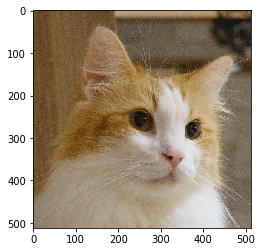

In [56]:
img_pred = cv2.imread('out of the box pic/test_cat_pic_1.jpg')

print(plt.imshow(cv2.cvtColor(img_pred, cv2.COLOR_BGR2RGB)))

img_pred = cv2.resize(img_pred,(img_height_reload,img_width_reload))
img_pred = np.reshape(img_pred,[1,img_height_reload,img_width_reload,3])

classes = (best_model.predict(img_pred) > 0.5).astype("int32")

print()
print('------------------------------------')
print('Predicted Class: ' + CATEGORIES[int(classes[0])])
print('------------------------------------')

AxesImage(54,36;334.8x217.44)

------------------------------------
Predicted Class: cats
------------------------------------


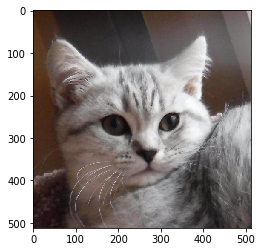

In [57]:
img_pred = cv2.imread('out of the box pic/test_cat_pic_2.jpg')

print(plt.imshow(cv2.cvtColor(img_pred, cv2.COLOR_BGR2RGB)))

img_pred = cv2.resize(img_pred,(img_height_reload,img_width_reload))
img_pred = np.reshape(img_pred,[1,img_height_reload,img_width_reload,3])

classes = (best_model.predict(img_pred) > 0.5).astype("int32")

print()
print('------------------------------------')
print('Predicted Class: ' + CATEGORIES[int(classes[0])])
print('------------------------------------')

AxesImage(54,36;334.8x217.44)

------------------------------------
Predicted Class: dogs
------------------------------------


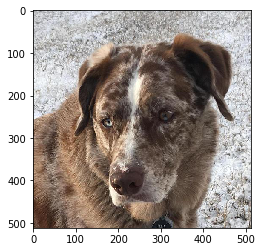

In [58]:
img_pred = cv2.imread('out of the box pic/test_dog_pic_1.jpg')

print(plt.imshow(cv2.cvtColor(img_pred, cv2.COLOR_BGR2RGB)))

img_pred = cv2.resize(img_pred,(img_height_reload,img_width_reload))
img_pred = np.reshape(img_pred,[1,img_height_reload,img_width_reload,3])

classes = (best_model.predict(img_pred) > 0.5).astype("int32")

print()
print('------------------------------------')
print('Predicted Class: ' + CATEGORIES[int(classes[0])])
print('------------------------------------')

AxesImage(54,36;334.8x217.44)

------------------------------------
Predicted Class: dogs
------------------------------------


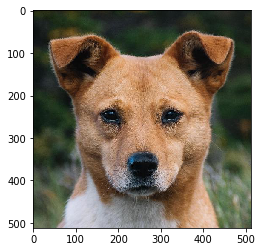

In [59]:
img_pred = cv2.imread('out of the box pic/test_dog_pic_2.jpg')

print(plt.imshow(cv2.cvtColor(img_pred, cv2.COLOR_BGR2RGB)))

img_pred = cv2.resize(img_pred,(img_height_reload,img_width_reload))
img_pred = np.reshape(img_pred,[1,img_height_reload,img_width_reload,3])

classes = (best_model.predict(img_pred) > 0.5).astype("int32")

print()
print('------------------------------------')
print('Predicted Class: ' + CATEGORIES[int(classes[0])])
print('------------------------------------')